In [236]:
from atmospheric_explorer.cams_interfaces import InversionOptimisedGreenhouseGas, EAC4Instance
from atmospheric_explorer.shapefile import ShapefilesDownloader
from atmospheric_explorer.utils import get_local_folder
from atmospheric_explorer.units_conversion import convert_units_array
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import os
from glob import glob
import xarray as xr
from datetime import datetime
import geopandas as gpd
from shapely.geometry import mapping
import rioxarray
import plotly.graph_objects as go
import shutil
import numpy as np
import statsmodels.stats.api as sms
import pandas as pd
import cdsapi

In [2]:
# Remove previous data
shutil.rmtree(os.path.join(get_local_folder(), 'data'))

In [3]:
# Remove previous data
shutil.rmtree(os.path.join(get_local_folder(), 'shapefiles'))

In [4]:
#function to move from 0+360 to -180+180 long
def ds_swaplon(ds):
    return ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')

In [5]:
manager = InversionOptimisedGreenhouseGas(
    data_variables='carbon_dioxide',
    file_format='zip',
    quantity='surface_flux',
    input_observations='surface',
    time_aggregation='monthly_mean',
    year=[
        '1985', '1986', '1987',
        '1988', '1989', '1990',
        '1991', '1992', '1993',
        '1994', '1995', '1996',
        '1997', '1998', '1999',
        '2000', '2001', '2002',
        '2003', '2004', '2005',
        '2006', '2007', '2008',
        '2009', '2010', '2011',
        '2012', '2013', '2014',
        '2015', '2016', '2017',
        '2018', '2019', '2020'
    ],
    month=[
        '01', '02', '03',
        '04', '05', '06',
        '07', '08', '09',
        '10', '11', '12'
    ]
)
manager.download()

INFO|cams_interfaces: Created folder C:\Users\ElisaAliverti\AppData\Local\AtmosphericExplorer\data\global_greenhouse_gas_inversion
INFO|cams_interfaces: Created folder C:\Users\ElisaAliverti\AppData\Local\AtmosphericExplorer\data\global_greenhouse_gas_inversion\data_2
INFO|cams_interfaces: Finished downloading file C:\Users\ElisaAliverti\AppData\Local\AtmosphericExplorer\data\global_greenhouse_gas_inversion\data_2\data_2.zip
INFO|cams_interfaces: Extracted file C:\Users\ElisaAliverti\AppData\Local\AtmosphericExplorer\data\global_greenhouse_gas_inversion\data_2\data_2.zip to folder C:\Users\ElisaAliverti\AppData\Local\AtmosphericExplorer\data\global_greenhouse_gas_inversion\data_2
INFO|cams_interfaces: Updated file_full_path to wildcard path C:\Users\ElisaAliverti\AppData\Local\AtmosphericExplorer\data\global_greenhouse_gas_inversion\data_2\*.nc
INFO|cams_interfaces: Removed C:\Users\ElisaAliverti\AppData\Local\AtmosphericExplorer\data\global_greenhouse_gas_inversion\data_2\data_2.zip


In [6]:
#sorted: ordina in ordine alfabetico  - globe: dentro è una lista (casting=viene 'converitito' in una lista)
files = sorted(glob(manager.file_full_path))

In [7]:
#cos'è un genereatore:
gen=(i for i in range(10))
#lista invece:
lista=[i for i in range(10)]

#come si scrive la lista [] o il generatore () si chiama list comprehension: permette di definire l'oggetto semplicemente con le parentesi

In [8]:
#il generatore se lo runni dura solo il tempo del print (se cambi gen con list non è cosi invece) - se lo runni di nuovo non contiene valori
for v in gen:
    print(v)

0
1
2
3
4
5
6
7
8
9


In [9]:
# Create dataframe with first file
mm = datetime.strptime(files[0].split('_')[-1].split('.')[0], '%Y%m')
df = xr.open_dataset(files[0])[['flux_foss']]
df = df.expand_dims({'time': [mm]})
# Merge remaining files
# ! This loop replaces xr.open_mfdataset(manager.file_full_path) that does not work (because time coordinate is not included in dataframe)
for file in files[1:]:
    mm = datetime.strptime(file.split('_')[-1].split('.')[0], '%Y%m')
    temp = xr.open_dataset(file)[['flux_foss']]
    temp = temp.expand_dims({'time': [mm]})
    df = xr.combine_by_coords([df, temp])

In [10]:
df = df.rio.write_crs('EPSG:4326')

In [11]:
sh_down = ShapefilesDownloader(
    resolution='10m',
    instance='countries'
)
sh_down.download_shapefile()

DEBUG|shapefile: Created ShapefilesDownloader object with attributes
dst_dir: C:\Users\ElisaAliverti\AppData\Local\AtmosphericExplorer\shapefiles
resolution: 10m
info_type: admin
depth: 0
instance: countries

INFO|shapefile: Created folder C:\Users\ElisaAliverti\AppData\Local\AtmosphericExplorer\shapefiles to save shapefiles
INFO|shapefile: Downloading shapefiles from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip
INFO|shapefile: Shapefiles downloaded to file C:\Users\ElisaAliverti\AppData\Local\AtmosphericExplorer\shapefiles\ne_10m_admin_0_countries.zip
INFO|shapefile: Shapefile extracted to C:\Users\ElisaAliverti\AppData\Local\AtmosphericExplorer\shapefiles\ne_10m_admin_0_countries
INFO|shapefile: Removed file C:\Users\ElisaAliverti\AppData\Local\AtmosphericExplorer\shapefiles\ne_10m_admin_0_countries.zip


In [12]:
sh = gpd.read_file(sh_down.shapefile_full_path, crs='EPSG:4326')

In [13]:
#all_touched=True questo parametro include tutti i pixel toccati dal poligono definito, se False include solo i pixel il cui centro è incluso nel poligono
#approvato all_touched=True
df_clipped = df.rio.clip(sh[sh['ADMIN'] == 'Italy'].geometry.apply(mapping), sh.crs, drop=True, all_touched=True)[['flux_foss']]

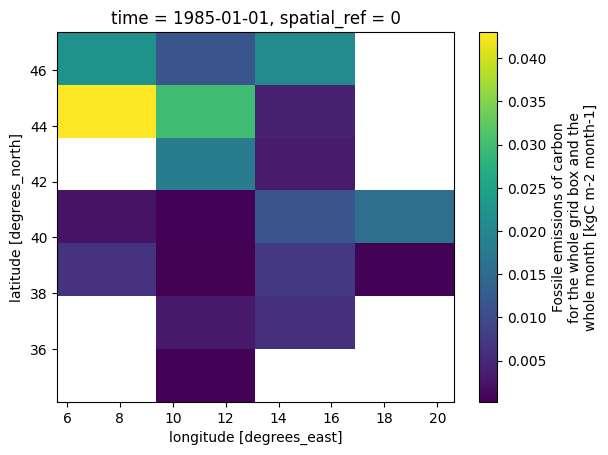

In [14]:
df_clipped['flux_foss'][0].plot()

In [15]:
# Drop all values that are null over all coords, compute the mean of the remaining values over long and lat
df_clipped = df_clipped.where(~df_clipped['flux_foss'].isnull(), drop=True).sortby('time').mean(dim=['longitude', 'latitude'])

In [16]:
da_converted=convert_units_array(df_clipped['flux_foss'], "carbon_dioxide")

<Axes: xlabel='year'>

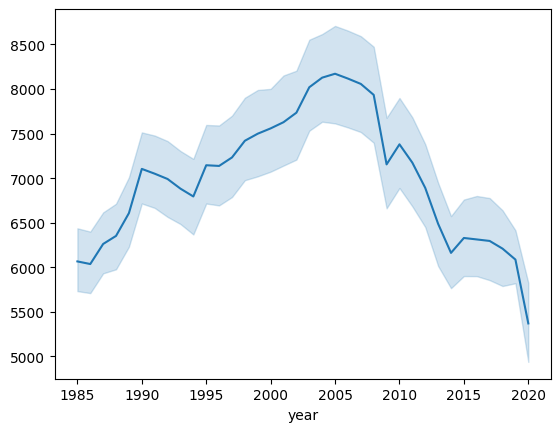

In [17]:
# Cool but not interactive
sns.lineplot(
    y=da_converted.values,
    x=da_converted.coords['time.year']
)

In [18]:
# Xarray doesn't cover all pandas functionalities, we need to convert it to a pandas dataframe
unit=da_converted.attrs["units"]
df_pandas = pd.DataFrame(da_converted.to_pandas(), columns=["flux_foss"]).reset_index()
df_pandas['year'] = df_pandas['time'].dt.year
df_pandas = df_pandas.groupby('year').agg(mean=('flux_foss', 'mean'), ci=('flux_foss', lambda d: sms.DescrStatsW(d).tconfint_mean()))
df_pandas[['lower', 'upper']] = pd.DataFrame(df_pandas['ci'].to_list(), index=df_pandas.index)

In [19]:
# Plotly plot, it's interactive, some tweaking needed for the theme
times = df_pandas.index.tolist()
times_rev = times[::-1]

# Line 1
y1 = df_pandas['mean'].to_list()
y1_upper = df_pandas['upper'].to_list()
y1_lower = df_pandas['lower'].to_list()
y1_lower = y1_lower[::-1]

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=times+times_rev,
    y=y1_upper+y1_lower,
    fill='toself',
    fillcolor='rgba(0,100,200,0.2)',
    line_color='rgba(0,100,200,0.2)',
    showlegend= False
))
fig.add_trace(go.Scatter(
    x=times,
    y=y1,
    line_color='rgb(0,100,200)',
    name="fossile flux"
))
fig.update_traces(mode='lines')
fig.update_xaxes(title='years')
fig.update_yaxes(title=unit)
fig.update_layout(title= {"text":"Fossile fluxes in Italy", "x":0.45, "y": 0.85, "automargin":True, "yref":"container", "font":{"size":19}})
fig.show()

In [20]:
# TODO:
## 1 - Shiftare lat e long se necessario -> EAC4 va da 0 a 360, ma Inversion è già tra -180+180
## 2 - Clip paese -> Capire se funziona, sembra funzionare
## 3 - Media annuale -> In realtà ci dovrebbe essere un modo per calcolare il CI su plotly, basta avere diversi valori per anno
##                    -> No, quella è seaborn, su plotly va fatto a mano usando ad esempio statsmodels
## 4 - Plot con CI al 95% e aggiugere la seconda linea

In [21]:
manager2 = EAC4Instance(
    'total_column_nitrogen_dioxide',
    'netcdf',
    dates_range = '2018-01-01/2020-01-01',
    time_values = '00:00'
)
manager2.download()

INFO|cams_interfaces: Created folder C:\Users\ElisaAliverti\AppData\Local\AtmosphericExplorer\data\eac4
INFO|cams_interfaces: Created folder C:\Users\ElisaAliverti\AppData\Local\AtmosphericExplorer\data\eac4\data_3
INFO|cams_interfaces: Finished downloading file C:\Users\ElisaAliverti\AppData\Local\AtmosphericExplorer\data\eac4\data_3\data_3.nc


In [22]:
df2 = xr.open_dataset(manager2.file_full_path)
df2

<xarray.Dataset>
Dimensions:    (longitude: 480, latitude: 241, time: 731)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2020-01-01
Data variables:
    tcno2      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-17 16:57:15 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [23]:
df2 = df2.rio.write_crs('EPSG:4326')

In [24]:
#all_touched=True questo parametro include tutti i pixel toccati dal poligono definito, se False include solo i pixel il cui centro è incluso nel poligono
#approvato all_touched=True
df2_clipped = df2.rio.clip(sh[sh['ADMIN'] == 'Italy'].geometry.apply(mapping), sh.crs, drop=True, all_touched=True)

In [25]:
df2_agg = df2_clipped.mean(dim=['latitude', 'longitude']).resample(time="1MS", restore_coord_dims=True).mean(dim='time')

In [26]:
reference_value = df2_agg.mean(dim='time')

In [27]:
reference_value

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int32 0
Data variables:
    tcno2        float32 3.561e-06

In [28]:
df2_agg

<xarray.Dataset>
Dimensions:      (time: 25)
Coordinates:
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2020-01-01
Data variables:
    tcno2        (time) float32 3.966e-06 4.145e-06 ... 3.759e-06 4.45e-06

In [29]:
df2_agg_convert = convert_units_array(df2_agg['tcno2'], 'total_column_nitrogen_dioxide')

In [30]:
reference_value = df2_agg_convert.mean().values

In [31]:
df2_agg_anomalies = df2_agg_convert - reference_value
df2_agg_anomalies.attrs = df2_agg_convert.attrs

In [32]:
df2_agg_convert

<xarray.DataArray 'tcno2' (time: 25)>
array([5.1911135, 5.425023 , 4.8040004, 3.954247 , 4.3154564, 4.433647 ,
       4.7209015, 4.786736 , 4.6467896, 4.626844 , 4.4398165, 5.5935454,
       5.5398126, 5.479846 , 4.501661 , 3.9954953, 4.009658 , 3.8310611,
       4.0634212, 4.1720366, 4.4358125, 4.290923 , 4.5044065, 4.920606 ,
       5.8247466], dtype=float32)
Coordinates:
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2020-01-01
Attributes:
    units:    10^15 molecules / cm2

In [33]:
fig = px.line(
    y=df2_agg_anomalies.values,
    x=df2_agg_anomalies.coords['time'],
    markers='o'
)
fig.update_xaxes(title="Month")
fig.update_yaxes(title=df2_agg_anomalies.attrs['units'])
fig.update_layout(
    title={
        "text": "Total columns N02 above Italy (anomalies)",
        "x": 0.45,
        "y": 0.95,
        "automargin": True,
        "yref": "container",
        "font": {
            "size":19
        }
    }
)

## Fourth plot
Hovmoeller O3

In [183]:
o3_manager = EAC4Instance(
    'total_column_ozone',
    'netcdf',
    dates_range = '2020-01-01/2022-12-31',
    time_values = '00:00',
)
o3_manager.download()

INFO|cams_interfaces: Created folder C:\Users\ElisaAliverti\AppData\Local\AtmosphericExplorer\data\eac4
INFO|cams_interfaces: Created folder C:\Users\ElisaAliverti\AppData\Local\AtmosphericExplorer\data\eac4\data_8
INFO|cams_interfaces: Finished downloading file C:\Users\ElisaAliverti\AppData\Local\AtmosphericExplorer\data\eac4\data_8\data_8.nc


In [184]:
df_o3 = xr.open_dataset(o3_manager.file_full_path)
df_o3 = df_o3.rio.write_crs('EPSG:4326')
df_o3

<xarray.Dataset>
Dimensions:      (longitude: 480, latitude: 241, time: 912)
Coordinates:
  * longitude    (longitude) float32 0.0 0.75 1.5 2.25 ... 357.8 358.5 359.2
  * latitude     (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time         (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2022-06-30
    spatial_ref  int32 0
Data variables:
    gtco3        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-18 15:44:17 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [185]:
df_o3_agg = df_o3.resample(time="1MS", restore_coord_dims=True).mean(dim='time').mean(dim='longitude')
df_o3_convert = convert_units_array(df_o3_agg['gtco3'], 'total_column_ozone')

In [241]:
fig = px.imshow(df_o3_convert.T, color_continuous_scale='Jet')
fig.show()

In [267]:
color_scale = px.colors.sequential.Jet
num_colors = 16
# if num_colors > len(color_scale):
#     interpolated_colors = []
#     for i in range(num_colors):
#         index = int(i * (len(color_scale) - 1) / (num_colors - 1))
#         interpolated_colors.append(color_scale[index])
#     discrete_colors = interpolated_colors
# else:
#     discrete_colors = color_scale

# import matplotlib.colors as mcolors
# if num_colors > len(color_scale):
#     cmap = mcolors.LinearSegmentedColormap.from_list('custom_color_scale', color_scale)
#     interpolated_colors = [mcolors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, num_colors)]
#     discrete_colors = interpolated_colors
# else:
#     discrete_colors = color_scale

# if num_colors > len(color_scale):
#     discrete_colors = []
#     for i in range(num_colors):
#         ratio = i / (num_colors - 1)
#         idx = int(ratio * (len(color_scale) - 1))
#         discrete_colors.append(color_scale[idx])
# else:
#     discrete_colors = color_scale[:num_colors]

# import matplotlib.colors as mcolors
# cmap = mcolors.LinearSegmentedColormap.from_list('custom_color_scale', color_scale)
# interpolated_colors = [mcolors.rgb2hex(cmap(i / (num_colors - 1))) for i in range(num_colors)]

import plotly.colors as pcolors
if num_colors > len(color_scale):
    interpolated_colors = pcolors.interpolate_colorscale(color_scale, num_colors)
    discrete_colors = [c for c, _ in interpolated_colors]
else:
    discrete_colors = color_scale[:num_colors]

fig = px.imshow(df_o3_convert.T, color_continuous_scale=discrete_colors)
fig.show()

AttributeError: module 'plotly.colors' has no attribute 'interpolate_colorscale'